<a href="https://colab.research.google.com/github/JamesHorrex/AI_stock_trading/blob/master/SS_AITrader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-0vomvxq2
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-0vomvxq2
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0f82f2a94252f97efd2cdbc57408469e1d4cd9774_-cp36-none-any.whl size=119874 sha256=89ed793efb9c66990b53af5e65bf86589a8490908bab030b28e094c2287dd825
  Stored in directory: /tmp/pip-ephem-wheel-cache-rle7hdq4/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [5]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
import pandas as pd 
df=pd.read_csv('gdrive/My Drive/SS_AITrader/df_AAPL_w_macro.csv')

In [7]:
df.head()

,timestamp,^vix,wr_5,wr_10,wr_15,mfi_5,mfi_10,mfi_15,ppo,roc_5,roc_10,roc_15,cmf_5,cmf_10,cmf_15,cmo_5,cmo_10,cmo_15,close_sma_5,close_sma_10,close_sma_15,open_sma_5,open_sma_10,open_sma_15,ema_5,ema_10,ema_15,wma_5,wma_10,wma_15,hma_0,hma_1,hma_2,trix_5,trix_10,trix_15,cci_5,cci_10,cci_15,dpo_5,dpo_10,dpo_15,kst_5,kst_10,kst_15,dmi_5,dmi_10,dmi_15,bb_5,bb_10,bb_15,fi_5,fi_10,fi_15,rsv_5,kdjk_5,rsv_10,kdjk_10,rsv_15,kdjk_15,eom_5,eom_10,eom_15,volume_delta,high_minus_low,close_minus_open,close_to_close,curve,curve_shift,^irx_change,^tnx_change,^vix_change,cny=x_change,jpy=x_change,labels
0,2015-01-23,16.660000,-9.005805,-9.005805,-8.442943,72.465975,57.971669,50.526604,0.323010,5.766714,0.974175,2.355505,0.269409,-0.026337,0.035697,78.772,7.233,10.467,109.928001,109.774001,109.281334,109.275999,110.212000,109.651333,110.923227,110.099342,109.823204,111.105335,109.986365,109.741751,114.052892,110.725305,142.153977,0.211160,-0.018010,-0.033946,103.757607,124.750463,133.500352,-1.208000,0.026002,-0.031334,-293.843045,-307.413795,-324.626496,23.314219,29.071140,33.532915,109.928001,109.774001,109.281334,5.040429e+07,5.040429e+07,5.040429e+07,90.994195,72.878272,90.994195,70.335449,91.557057,71.128494,7.381712,7.381712,7.381712,-7331600.0,0.019650,0.006055,0.005160,1.804,-1.077,-0.002,-0.079,0.260000,-0.000435,0.007560,2.0
1,2015-01-26,15.520000,-16.030560,-13.755476,-12.949658,100.000000,58.179270,57.108232,0.466025,6.708181,0.973124,3.448273,0.262863,-0.105227,-0.003052,100.000,7.233,15.767,111.350002,109.883001,109.532668,110.617999,110.318999,109.808000,111.649554,110.663532,110.279994,112.162668,110.591092,110.219084,114.127556,112.603729,121.421460,0.339265,0.022707,-0.019595,87.350131,132.828930,132.296306,-1.799998,-3.063001,0.687334,-285.519144,-296.218423,-313.183608,24.980228,28.925920,32.791890,111.350002,109.883001,109.532668,3.582737e+07,3.582737e+07,3.582737e+07,83.969440,76.575328,86.244524,75.638474,87.050342,76.435777,2.636701,2.636701,2.636701,9150200.0,0.013793,-0.005627,0.001062,1.823,-0.981,-0.008,0.011,-1.139999,0.003049,-0.011705,0.0
2,2015-01-27,17.219999,-85.714250,-56.986890,-53.648504,68.468290,53.745445,54.919817,0.343820,0.386312,-0.100687,2.719999,-0.208030,-0.182414,-0.069969,5.036,-0.676,11.658,111.434001,109.872001,109.725334,111.534000,110.300999,110.083333,110.812470,110.378840,110.123333,111.426000,110.456001,110.170001,110.981776,112.813466,111.103207,0.272731,0.040895,-0.010339,-67.849364,8.592128,16.665564,0.966000,-3.882003,0.074669,-278.036210,-285.134427,-301.817544,24.032144,27.649804,31.306843,111.434001,109.872001,109.725334,-1.022657e+08,-1.022657e+08,-1.022657e+08,14.285750,55.812135,43.013110,64.763353,46.351496,66.407683,-10.198177,-10.198177,-10.198177,39953700.0,0.031611,-0.029176,-0.035013,1.807,-1.016,0.013,-0.003,1.699999,0.004487,0.009875,1.0
3,2015-01-28,20.440001,-30.913135,-21.749256,-21.749256,76.648565,59.590262,65.798643,0.602797,5.257868,4.618033,8.516841,-0.514890,-0.343395,-0.228957,42.105,23.707,29.241,112.586000,110.381001,110.328667,113.270000,110.920999,110.822666,112.312322,111.295665,110.827351,112.717999,111.444727,110.868084,112.357108,113.416676,112.051109,0.364361,0.078750,0.006096,142.222208,161.758811,204.235526,0.394003,-1.660999,-3.508668,-267.170503,-270.651513,-286.944750,24.318434,27.134181,30.425085,112.586000,110.381001,110.328667,2.330773e+08,2.330773e+08,2.330773e+08,69.086865,60.237045,78.250744,69.259150,78.250744,70.355370,11.433615,11.433615,11.433615,50908400.0,0.024369,-0.019723,0.056533,1.709,-1.098,-0.003,-0.101,3.220001,-0.001713,-0.006286,1.0
4,2015-01-29,18.760000,-2.854339,-2.072915,-2.072915,78.530401,68.548221,67.529590,1.001082,5.782918,8.287794,10.348029,-0.431673,-0.248697,-0.163782,45.076,36.932,33.737,113.886000,111.291000,111.072001,114.481999,111.648999,111.430666,114.508876,112.703717,111.911462,114.822666,112.993637,111.939500,118.318888,115.055605,113.615311,0.584832,0.143210,0.033003,106.364237,145.277739,200.347092,-0.786

In [8]:
df.drop(['timestamp'], inplace=True, axis=1)

In [9]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

In [10]:
train_dataset.head()

,^vix,wr_5,wr_10,wr_15,mfi_5,mfi_10,mfi_15,ppo,roc_5,roc_10,roc_15,cmf_5,cmf_10,cmf_15,cmo_5,cmo_10,cmo_15,close_sma_5,close_sma_10,close_sma_15,open_sma_5,open_sma_10,open_sma_15,ema_5,ema_10,ema_15,wma_5,wma_10,wma_15,hma_0,hma_1,hma_2,trix_5,trix_10,trix_15,cci_5,cci_10,cci_15,dpo_5,dpo_10,dpo_15,kst_5,kst_10,kst_15,dmi_5,dmi_10,dmi_15,bb_5,bb_10,bb_15,fi_5,fi_10,fi_15,rsv_5,kdjk_5,rsv_10,kdjk_10,rsv_15,kdjk_15,eom_5,eom_10,eom_15,volume_delta,high_minus_low,close_minus_open,close_to_close,curve,curve_shift,^irx_change,^tnx_change,^vix_change,cny=x_change,jpy=x_change,labels
1157,13.740000,-49.967445,-34.549546,-30.173087,77.348662,78.697020,64.807860,1.898898,2.574325,4.660067,2.960554,0.263309,0.239783,0.127906,36.190,37.347,13.403,219.259998,214.646999,211.619999,218.314001,214.260001,211.890000,218.879971,215.932147,213.871256,220.296664,217.328725,214.839165,222.201999,223.103168,220.616605,0.660100,0.308656,0.180381,2.578989,67.401194,93.408531,-2.560001,-1.367000,-5.920002,40.055364,40.000234,40.601764,34.427781,29.663715,27.898671,219.259998,214.646999,211.619999,-2.949592e+06,-2.949592e+06,-2.949592e+06,50.032555,74.084679,65.450454,80.388903,69.826913,82.781229,-54.373981,-54.373981,-54.373981,7536600.0,0.017234,-0.005682,-0.019454,0.003,-0.893,0.005,0.112,-0.480000,-0.005256,0.001435,1.0
445,16.190001,-91.881121,-91.881121,-92.379121,34.703351,37.398926,54.302483,0.891279,-2.469981,-3.323979,-0.149265,0.333082,0.248059,0.069919,-46.602,-54.230,-1.457,115.938000,116.549001,116.520000,115.723999,116.505000,116.605332,115.292804,115.832148,115.715698,115.162667,116.017819,116.359834,113.058003,115.147334,116.132105,-0.154700,0.149546,0.204501,-76.751639,-135.788569,-141.855791,2.312000,0.510997,0.950001,47.788855,49.587277,51.121123,25.589288,26.447036,26.881509,115.938000,116.549001,116.520000,-3.993176e+07,-3.993176e+07,-3.993176e+07,8.118879,39.043902,8.118879,38.552197,7.620879,39.661511,-3.021534,-3.021534,-3.021534,3299700.0,0.015477,-0.001317,-0.006639,1.572,-0.996,-0.002,0.002,0.830001,0.002231,0.006178,2.0
458,13.350000,-16.262486,-23.167597,-50.169816,52.636288,43.944417,30.433928,-1.316411,-0.838745,-1.469665,-4.879314,0.225553,0.250470,0.030704,-9.800,-11.202,-29.936,108.109999,109.156999,110.425999,108.375998,109.165999,110.628666,109.096052,109.673730,110.466315,108.683332,108.915999,109.455666,110.804886,107.807797,107.690849,-0.302262,-0.323479,-0.139691,96.489297,38.640341,-24.595085,-2.400000,1.902998,-1.586003,-44.296611,-47.181630,-48.983537,53.138972,52.050359,49.114338,108.109999,109.156999,110.425999,2.147963e+07,2.147963e+07,2.147963e+07,83.737514,63.039833,76.832403,52.688880,49.830184,36.009972,6.463502,6.463502,6.463502,-31208500.0,0.013824,0.001275,-0.000364,1.856,-0.914,-0.033,0.053,-0.370000,-0.010047,-0.002320,2.0
251,22.340000,-0.497524,-0.497524,-41.219694,53.344641,43.893538,28.719193,-3.421902,1.909166,5.152930,-5.497579,0.360456,0.105475,-0.044847,22.093,29.566,-21.177,97.660001,98.066000,99.408666,97.079999,98.175000,99.757333,98.535227,98.962607,100.142585,98.208001,98.103273,98.401000,99.512000,97.364143,96.971662,-0.282359,-0.596240,-0.530609,166.666667,137.025752,26.601618,-0.999997,-0.676000,-0.878667,-116.812768,-121.148423,-123.898601,51.111369,53.000176,52.468258,97.660001,98.066000,99.408666,9.389201e+07,9.389201e+07,9.389201e+07,99.502476,58.248013,99.502476,51.994836,58.780306,30.963008,16.459511,16.459511,16.459511,13639000.0,0.030467,0.028288,0.053167,1.760,-0.986,0.015,0.029,-4.350000,0.000244,0.006744,0.0
1252,16.049999,-35.115093,-35.115093,-35.115093,41.962637,50.398234,46.920761,2.335417,0.365137,0.720219,0.596294,0.067664,0.078555,0.041191,3.567,4.207,2.725,317.046002,316.711005,316.111336,317.106000,316.494000,316.036001,315.637861,315.409416,313.694968,315.300004,316.199822,316.378254,311.492896,314.581569,316.279739,-0.032331,0.320679,0.449566,2.934820,11.701300,23.986806,6.823993,-7.760992,3.118675,106.356690,107.796533,110.916645,27.268141,35.671296,40.656

In [11]:
train_labels = train_dataset.pop('labels')
test_labels = test_dataset.pop('labels')

In [12]:
train_labels.head()

1157    1.0
445     2.0
458     2.0
251     0.0
1252    1.0
Name: labels, dtype: float64

In [13]:
from sklearn.utils import compute_class_weight
def get_sample_weights(y):
      y = y.astype(int)  # compute_class_weight needs int labels
      class_weights = compute_class_weight('balanced', np.unique(y), y)

      print("real class weights are {}".format(class_weights), np.unique(y))
      print("value_counts", np.unique(y, return_counts=True))
      sample_weights = y.copy().astype(float)
      for i in np.unique(y):
          sample_weights[sample_weights == i] = class_weights[i]  # if i == 2 else 0.8 * class_weights[i]
            # sample_weights = np.where(sample_weights == i, class_weights[int(i)], y_)

      return sample_weights


In [14]:
get_sample_weights(train_labels)

real class weights are [0.85829308 0.71639785 2.27777778] [0 1 2]
value_counts (array([0, 1, 2]), array([414, 496, 156]))


1157    0.716398
445     2.277778
458     2.277778
251     0.858293
1252    0.716398
          ...   
584     2.277778
147     0.716398
160     0.716398
750     0.858293
859     0.716398
Name: labels, Length: 1066, dtype: float64

In [15]:
SAMPLE_WEIGHT=get_sample_weights(train_labels)

real class weights are [0.85829308 0.71639785 2.27777778] [0 1 2]
value_counts (array([0, 1, 2]), array([414, 496, 156]))


In [16]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

In [17]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [51]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from operator import itemgetter

list_features = list(normed_train_data.columns)
select_k_best = SelectKBest(f_classif, k=10)
select_k_best.fit(normed_train_data, train_labels)
selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)

selected_features_anova

('^vix',
 'mfi_15',
 'ppo',
 'cmf_15',
 'cmo_15',
 'cci_15',
 'kdjk_10',
 'rsv_15',
 'kdjk_15',
 'high_minus_low')

In [52]:
select_k_best = SelectKBest(mutual_info_classif, k=10)
select_k_best.fit(normed_train_data, train_labels)
selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)
selected_features_mic

('mfi_10',
 'roc_15',
 'cmo_5',
 'trix_5',
 'cci_10',
 'cci_15',
 'dpo_10',
 'kst_15',
 'fi_10',
 'fi_15')

In [61]:
X_new = SelectKBest(f_classif, k=10).fit_transform(normed_train_data, train_labels)
X_new.shape


10

In [63]:
def build_model(hidden_dim,dropout=0.4):
    ## input layer
    inputs=tf.keras.Input(shape=(X_new.shape[1],))


    h1= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(inputs)
    h2= tf.keras.layers.Dropout(dropout)(h1)
    h3= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h2)
    h4= tf.keras.layers.Dropout(dropout)(h3)
    h5= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h4)
    h6= tf.keras.layers.Dropout(dropout)(h5)
    h7= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(h6)

    ##output
    outputs=tf.keras.layers.Dense(units=3,activation='softmax')(h7)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [65]:
criterion = tf.keras.losses.sparse_categorical_crossentropy

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model = build_model(hidden_dim=64)

model.compile(optimizer=optimizer,loss=criterion,metrics=['accuracy'])

In [67]:
example_batch = X_new[:10]
example_result = model.predict(example_batch)
example_result

array([[0.3311944 , 0.35434002, 0.31446558],
       [0.31916222, 0.34007797, 0.34075978],
       [0.34260046, 0.32366696, 0.33373263],
       [0.38656625, 0.27579185, 0.3376419 ],
       [0.33449885, 0.33141133, 0.33408988],
       [0.3472859 , 0.32995555, 0.32275853],
       [0.3371171 , 0.33598062, 0.32690224],
       [0.33492658, 0.3641351 , 0.3009383 ],
       [0.36553568, 0.2540086 , 0.38045576],
       [0.32678768, 0.3375403 , 0.33567202]], dtype=float32)

In [68]:
EPOCHS=1000
BATCH_SIZE=120

history = model.fit(
  X_new, train_labels,
  epochs=EPOCHS, batch_size=BATCH_SIZE ,sample_weight=SAMPLE_WEIGHT,validation_split = 0.2, verbose=1,
  callbacks=[tfdocs.modeling.EpochDots()])

Epoch 1/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.1604 - accuracy: 0.3417
Epoch: 0, accuracy:0.3791,  loss:1.1280,  val_accuracy:0.4346,  val_loss:1.1072,  
8/8 [==============================] - 0s 28ms/step - loss: 1.1280 - accuracy: 0.3791 - val_loss: 1.1072 - val_accuracy: 0.4346
Epoch 2/1000
8/8 [==============================] - 0s 13ms/step - loss: 1.1061 - accuracy: 0.4108 - val_loss: 1.0994 - val_accuracy: 0.3785
Epoch 3/1000
8/8 [==============================] - 0s 12ms/step - loss: 1.0802 - accuracy: 0.3850 - val_loss: 1.0962 - val_accuracy: 0.3318
Epoch 4/1000
8/8 [==============================] - 0s 12ms/step - loss: 1.1118 - accuracy: 0.3509 - val_loss: 1.0929 - val_accuracy: 0.3411
Epoch 5/1000
8/8 [==============================] - 0s 12ms/step - loss: 1.0837 - accuracy: 0.4061 - val_loss: 1.0912 - val_accuracy: 0.3224
Epoch 6/1000
8/8 [==============================] - 0s 12ms/step - loss: 1.0955 - accuracy: 0.3627 - val_loss: 1.0904 - val_accurac

In [69]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
995,0.779189,0.588028,1.451715,0.397196,995
996,0.739589,0.603286,1.464613,0.411215,996
997,0.731846,0.631455,1.464451,0.397196,997
998,0.719753,0.592723,1.456988,0.401869,998
999,0.728607,0.599765,1.452050,0.392523,999


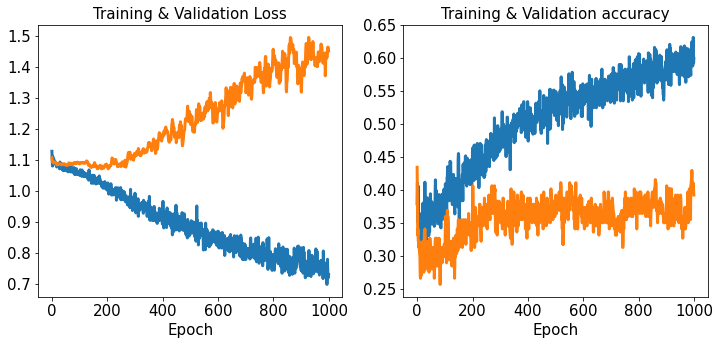

In [70]:
import matplotlib.pyplot as plt

hist=history.history

fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
ax.plot(hist['loss'],lw=3)
ax.plot(hist['val_loss'],lw=3)
ax.set_title('Training & Validation Loss',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax=fig.add_subplot(1,2,2)
ax.plot(hist['accuracy'],lw=3)
ax.plot(hist['val_accuracy'],lw=3)
ax.set_title('Training & Validation accuracy',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
plt.show()


